In [61]:
import pandas as pd
import numpy as np
import os
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Bidirectional
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# dir_path = './' #local
dir_path = './drive/MyDrive/BAKA/' #colab

In [62]:
#uncomment in colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
files = os.listdir(dir_path + 'Merged')
files

['gestures_train.csv', 'gestures_test.csv']

In [64]:
df_train = pd.read_csv(dir_path + 'Merged/gestures_train.csv')
df_test = pd.read_csv(dir_path + 'Merged/gestures_test.csv')
num_classes = len(df_train.label.unique())
df_train

,label,a1,a2,ab,b1,b2,bc,c1,c2,cd,d1,d2,de,e1,e2,px,py,pz,x0,x1,x2,x3,x4,y0,y1,y2,y3,y4,z0,z1,z2,z3,z4
0,1,171.917694,132.738831,116.083084,168.437363,169.912949,2.744997,95.554222,125.426796,1.433788,98.878227,127.633797,0.321749,98.652611,128.144958,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,172.026489,132.672134,116.079544,168.437363,169.912949,0.662870,95.559898,125.403061,2.515430,98.879311,127.635490,0.075647,98.653168,128.149155,-0.004623,0.011925,0.012167,59.335590,-0.010059,0.011242,0.008318,0.011974,41.752968,0.023743,0.069817,0.022484,0.015427,-60.686092,0.031288,-0.019450,0.028371,0.025351
2,1,172.049591,132.658401,116.078300,168.437317,169.913010,1.706766,95.556076,125.403023,1.034447,98.879570,127.635902,0.919123,98.653290,128.150757,-0.000923,0.002502,0.002552,0.001617,-0.002472,-0.004000,0.002121,0.002968,0.004364,0.005936,0.000786,0.005386,0.003067,0.007065,0.008162,0.010556,0.006170,0.006201
3,1,172.071579,132.642776,116.077629,168.437347,169.912949,0.455037,95.549484,125.403069,0.707033,98.879860,127.636314,1.301736,98.654289,128.151947,-0.000923,0.002495,0.002548,0.000597,-0.002464,-0.007114,0.002119,0.003578,0.004433,0.005936,-0.003082,0.005371,0.004326,0.007211,0.008144,0.013555,0.006168,0.004779
4,1,172.092804,132.627594,116.077316,168.437347,169.912933,2.034597,95.544991,125.404495,1.652241,98.880104,127.636703,0.060266,98.655296,128.153198,-0.003822,0.000137,0.001204,-0.002567,-0.008404,-0.008961,-0.001764,-0.000450,0.004295,0.002213,-0.005486,0.002556,0.000992,0.004589,0.001745,0.009327,0.003395,0.003071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161795,30,155.428940,174.586319,110.989807,168.322968,170.471313,0.891064,100.356743,141.077988,0.197881,101.467400,141.111938,2.246739,101.672791,141.356110,2.728947,0.310066,-0.266518,2.494905,3.028548,2.748571,2.845219,2.946190,0.300800,0.270683,0.573120,0.451969,0.419716,-0.081818,-0.191807,-0.038231,-0.073334,-0.167938
161796,30,155.546890,175.031281,111.164673,168.517853,170.631866,1.755110,100.357552,141.073151,0.849069,101.470001,141.112167,2.527119,101.694633,141.341766,3.301022,-0.286476,-0.032745,3.242838,2.957266,3.351566,3.343557,3.401852,-0.127975,0.304504,-0.441071,-0.423367,-0.339947,-0.481194,-0.374904,-0.335571,-0.306252,-0.319984
161797,30,155.883240,175.916321,111.659500,168.709732,170.790070,0.870190,100.386345,141.060516,1.251321,101.470955,141.110825,0.360201,101.697769,141.347458,1.644402,-0.627548,0.043282,1.661020,2.078659,1.358609,1.262947,1.341320,-0.388813,-0.135117,-1.058586,-0.907379,-0.691280,-0.401161,0.119175,-0.086823,-0.160332,-0.248985
161798,30,156.244843,176.664246,112.280891,168.823837,170.889343,1.974926,100.382736,141.060654,0.438103,101.471176,141.109833,1.286202,101.696381,141.344925,2.793831,-1.372391,-0.906891,2.365389,2.463518,2.307763,2.223122,2.245644,-0.584534,1.845512,-2.698456,-2.489361,-1.933666,-3.416515,-1.572324,-2.387756,-2.609138,-2.599831


In [65]:
def calculation(df_rows):
    res = {'omega0': [],
           'omega1': [],
           'omega2': [],
           'omega3': [],
           'omega4': [],
           'beta0': [],
           'beta1': [],
           'beta2': [],
           'beta3': [],
           'beta4': [],
           'u0':[],
           'u1':[],
           'u2':[],
           'u3':[],
           'u4':[],
           'u5':[],
           'v0':[],
           'v1':[],
           'v2':[],
           'v3':[],
           'v4':[],
           'v5':[],
           'z0':[],
           'z1':[],
           'z2':[],
           'z3':[],
           'z4':[],
           'z5':[],
           'gamma3': [],
           'gamma2': [],
           'gamma1': []
          }
    for index, row in df_rows.iterrows():
        #intra-finger angles
        res['gamma3'].append(row['ab'])
        res['gamma2'].append(row['bc'])
        res['gamma1'].append(row['cd'])
        
        #finger tip coordinates
        res['u0'].append(row['x0'])
        res['u1'].append(row['x1'])
        res['u2'].append(row['x2'])
        res['u3'].append(row['x3'])
        res['u4'].append(row['x4'])
        
        res['v0'].append(row['y0'])
        res['v1'].append(row['y1'])
        res['v2'].append(row['y2'])
        res['v3'].append(row['y3'])
        res['v4'].append(row['y4'])
        
        res['z0'].append(row['z0'])
        res['z1'].append(row['z1'])
        res['z2'].append(row['z2'])
        res['z3'].append(row['z3'])
        res['z4'].append(row['z4'])
        
        #palm coordinates
        res['u5'].append(row['px'])
        res['v5'].append(row['py'])
        res['z5'].append(row['pz'])
        
        #joint angles omega
        res['omega0'].append(row['e1'])
        res['omega1'].append(row['d1'])
        res['omega2'].append(row['c1'])
        res['omega3'].append(row['b1'])
        res['omega4'].append(row['a1'])
        
        #joint angles beta
        res['beta0'].append(row['e2'])
        res['beta1'].append(row['d2'])
        res['beta2'].append(row['c2'])
        res['beta3'].append(row['b2'])
        res['beta4'].append(row['a2'])
    res = pd.DataFrame(res)
    return res.to_numpy()

In [66]:
def scale_data(data, min_max_scaler):
    for i in range(len(data)):
        data[i] = min_max_scaler.transform(data[i])
    return data

def map_features(df):
    output_df = []
    output_label = []

    for i in range(200,len(df)+1,200):
        if i == 200:
            output_df.append(np.copy(calculation(df[:i])))
            output_label.append(df[:i]['label'][i-1]-1)
        else:
            output_df.append(np.copy(calculation(df[(i-200):i])))
            output_label.append(df[(i-200):i]['label'][i-1]-1)
    return np.array(output_df), np.array(output_label)


    

In [67]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))
x_train, y_train = map_features(df_train)

num_instances, num_time_steps, num_features = x_train.shape
x_train = np.reshape(x_train, newshape=(-1, num_features))
x_train = min_max_scaler.fit_transform(x_train)
x_train = np.reshape(x_train, newshape=(num_instances, num_time_steps, num_features))

x_train, y_train = shuffle(x_train, y_train, random_state=0)

x_test, y_test = map_features(df_test)
num_instances, num_time_steps, num_features = x_test.shape
x_test = np.reshape(x_test, newshape=(-1, num_features))
x_test = min_max_scaler.transform(x_test)
x_test = np.reshape(x_test, newshape=(num_instances, num_time_steps, num_features))

x_test, y_test = shuffle(x_test, y_test, random_state=0)


In [68]:
# x_train = np.delete(x_train, [0,1,2,3,4,5,6,7,8], 0)
# y_train = np.delete(y_train, [0,1,2,3,4,5,6,7,8], 0)
print("x_train.shape: ", x_train.shape)
print("y_train.shiape: ", y_train.shape)
print("x_test.shape: ", x_test.shape)
print("y_test.shape: ", y_test.shape)
# print(y_train)
# print("\n")
# print(y_test)

# print(x_train)
y_train = y_train.astype('int')

# print(y_train)


x_train.shape:  (809, 200, 31)
y_train.shiape:  (809,)
x_test.shape:  (389, 200, 31)
y_test.shape:  (389,)


In [69]:
print(x_train.shape[2])

31


In [70]:
def define_models(drop_rate, number_of_classes):
  models = [Sequential(), Sequential(), Sequential(),Sequential(), Sequential()]
  models[0].add(Bidirectional(LSTM(units=200 ,dtype='float64'),input_shape=x_train.shape[1:],dtype='float64'))
  models[0].add(BatchNormalization())
  models[0].add(Dropout(drop_rate))
  models[0].add(Dense(number_of_classes, activation='softmax',dtype='float64'))

  for i in range(1,len(models)):
    models[i].add(Bidirectional(LSTM(units=200, return_sequences=True ,dtype='float64'),input_shape=x_train.shape[1:],dtype='float64'))
    models[i].add(BatchNormalization())
    models[i].add(Dropout(drop_rate))

    # for k in range(0, i-2):
    #   models[i].add(Bidirectional(LSTM(units=200, return_sequences=True ,dtype='float64') ,dtype='float64'))
    #   models[i].add(BatchNormalization())
    #   models[i].add(Dropout(drop_rate))

    models[i].add(Bidirectional(LSTM(units=200 ,dtype='float64') ,dtype='float64'))
    models[i].add(BatchNormalization())
    models[i].add(Dropout(drop_rate))
    
    models[i].add(Dense(number_of_classes, activation='softmax',dtype='float64'))
  
  return models




In [71]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-5)
gestures = []
models = {}

for drop_rate in [ 0.0, 0.1, 0.2, 0.3, 0.4, 0.5,  0.6]: #0.7,  0.8,  0.9 ]:
  models[drop_rate] = define_models(drop_rate, num_classes)
  layer = 1
  for m in models[drop_rate]:
    print("***** dropout [", drop_rate, "][",layer,"] *******")
    m.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy'],
    )

    gestures.append(m.fit(x = x_train,
              y = y_train,
              epochs=120,
              validation_split=0.1, #split 10% of the trainning set for the validation set,
              batch_size=24,
              shuffle=True
            ))
    m.save(dir_path + 'Models/gestures_' + str(drop_rate) +'_'+str(layer), save_format='tf')
    layer += 1


***** dropout [ 0.0 ][ 1 ] *******
Epoch 1/120
31/31 [==============================] - 5s 83ms/step - loss: 3.0101 - accuracy: 0.1648 - val_loss: 3.3039 - val_accuracy: 0.0741
Epoch 2/120
31/31 [==============================] - 2s 65ms/step - loss: 1.8466 - accuracy: 0.4986 - val_loss: 3.1667 - val_accuracy: 0.1728
Epoch 3/120
31/31 [==============================] - 2s 65ms/step - loss: 1.3931 - accuracy: 0.6648 - val_loss: 3.0258 - val_accuracy: 0.2840
Epoch 4/120
31/31 [==============================] - 2s 65ms/step - loss: 1.1418 - accuracy: 0.7541 - val_loss: 2.8668 - val_accuracy: 0.3704
Epoch 5/120
31/31 [==============================] - 2s 64ms/step - loss: 0.9558 - accuracy: 0.8022 - val_loss: 2.6432 - val_accuracy: 0.4691
Epoch 6/120
31/31 [==============================] - 2s 65ms/step - loss: 0.8505 - accuracy: 0.8379 - val_loss: 2.4333 - val_accuracy: 0.4815
Epoch 7/120
31/31 [==============================] - 2s 65ms/step - loss: 0.7462 - accuracy: 0.8585 - val_loss: 2

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.0_1/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.0_1/assets


***** dropout [ 0.0 ][ 2 ] *******
Epoch 1/120
31/31 [==============================] - 10s 171ms/step - loss: 1.4572 - accuracy: 0.6154 - val_loss: 3.1778 - val_accuracy: 0.0988
Epoch 2/120
31/31 [==============================] - 4s 137ms/step - loss: 0.8061 - accuracy: 0.7761 - val_loss: 3.0683 - val_accuracy: 0.2222
Epoch 3/120
31/31 [==============================] - 4s 137ms/step - loss: 0.6716 - accuracy: 0.8255 - val_loss: 2.9349 - val_accuracy: 0.3333
Epoch 4/120
31/31 [==============================] - 4s 136ms/step - loss: 0.5189 - accuracy: 0.8777 - val_loss: 2.7650 - val_accuracy: 0.3704
Epoch 5/120
31/31 [==============================] - 4s 136ms/step - loss: 0.4825 - accuracy: 0.8819 - val_loss: 2.5886 - val_accuracy: 0.4198
Epoch 6/120
31/31 [==============================] - 4s 136ms/step - loss: 0.4386 - accuracy: 0.8915 - val_loss: 2.3790 - val_accuracy: 0.4568
Epoch 7/120
31/31 [==============================] - 4s 137ms/step - loss: 0.4164 - accuracy: 0.8805 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.0_2/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.0_2/assets


***** dropout [ 0.0 ][ 3 ] *******
Epoch 1/120
31/31 [==============================] - 11s 172ms/step - loss: 1.6945 - accuracy: 0.5659 - val_loss: 3.1951 - val_accuracy: 0.2099
Epoch 2/120
31/31 [==============================] - 4s 136ms/step - loss: 0.8072 - accuracy: 0.7967 - val_loss: 3.0791 - val_accuracy: 0.2593
Epoch 3/120
31/31 [==============================] - 4s 137ms/step - loss: 0.6937 - accuracy: 0.8228 - val_loss: 2.9294 - val_accuracy: 0.3210
Epoch 4/120
31/31 [==============================] - 4s 136ms/step - loss: 0.5625 - accuracy: 0.8503 - val_loss: 2.7764 - val_accuracy: 0.3457
Epoch 5/120
31/31 [==============================] - 4s 137ms/step - loss: 0.4950 - accuracy: 0.8736 - val_loss: 2.6173 - val_accuracy: 0.4074
Epoch 6/120
31/31 [==============================] - 4s 136ms/step - loss: 0.4671 - accuracy: 0.8736 - val_loss: 2.3856 - val_accuracy: 0.4568
Epoch 7/120
31/31 [==============================] - 4s 136ms/step - loss: 0.4105 - accuracy: 0.8984 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.0_3/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.0_3/assets


***** dropout [ 0.0 ][ 4 ] *******
Epoch 1/120
31/31 [==============================] - 10s 176ms/step - loss: 1.4711 - accuracy: 0.5975 - val_loss: 3.1923 - val_accuracy: 0.1358
Epoch 2/120
31/31 [==============================] - 4s 138ms/step - loss: 0.7607 - accuracy: 0.7926 - val_loss: 3.0713 - val_accuracy: 0.2593
Epoch 3/120
31/31 [==============================] - 4s 139ms/step - loss: 0.6377 - accuracy: 0.8379 - val_loss: 2.9666 - val_accuracy: 0.2963
Epoch 4/120
31/31 [==============================] - 4s 139ms/step - loss: 0.5656 - accuracy: 0.8503 - val_loss: 2.8215 - val_accuracy: 0.2840
Epoch 5/120
31/31 [==============================] - 4s 139ms/step - loss: 0.4705 - accuracy: 0.8819 - val_loss: 2.6487 - val_accuracy: 0.3704
Epoch 6/120
31/31 [==============================] - 4s 139ms/step - loss: 0.4414 - accuracy: 0.8805 - val_loss: 2.4423 - val_accuracy: 0.5062
Epoch 7/120
31/31 [==============================] - 4s 138ms/step - loss: 0.4446 - accuracy: 0.8832 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.0_4/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.0_4/assets


***** dropout [ 0.0 ][ 5 ] *******
Epoch 1/120
31/31 [==============================] - 11s 221ms/step - loss: 1.5082 - accuracy: 0.6044 - val_loss: 3.2150 - val_accuracy: 0.0123
Epoch 2/120
31/31 [==============================] - 4s 139ms/step - loss: 0.7618 - accuracy: 0.8036 - val_loss: 3.1390 - val_accuracy: 0.0988
Epoch 3/120
31/31 [==============================] - 4s 139ms/step - loss: 0.6613 - accuracy: 0.8255 - val_loss: 3.0273 - val_accuracy: 0.2222
Epoch 4/120
31/31 [==============================] - 4s 139ms/step - loss: 0.5302 - accuracy: 0.8599 - val_loss: 2.8788 - val_accuracy: 0.2840
Epoch 5/120
31/31 [==============================] - 4s 139ms/step - loss: 0.4679 - accuracy: 0.8832 - val_loss: 2.7089 - val_accuracy: 0.3704
Epoch 6/120
31/31 [==============================] - 4s 138ms/step - loss: 0.4074 - accuracy: 0.8860 - val_loss: 2.5054 - val_accuracy: 0.4691
Epoch 7/120
31/31 [==============================] - 4s 139ms/step - loss: 0.4034 - accuracy: 0.8970 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.0_5/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.0_5/assets


***** dropout [ 0.1 ][ 1 ] *******
Epoch 1/120
31/31 [==============================] - 5s 87ms/step - loss: 2.0249 - accuracy: 0.4203 - val_loss: 3.0074 - val_accuracy: 0.2469
Epoch 2/120
31/31 [==============================] - 2s 67ms/step - loss: 0.9959 - accuracy: 0.7500 - val_loss: 2.8217 - val_accuracy: 0.2840
Epoch 3/120
31/31 [==============================] - 2s 67ms/step - loss: 0.8286 - accuracy: 0.7830 - val_loss: 2.6274 - val_accuracy: 0.6790
Epoch 4/120
31/31 [==============================] - 2s 67ms/step - loss: 0.7206 - accuracy: 0.8379 - val_loss: 2.5436 - val_accuracy: 0.3951
Epoch 5/120
31/31 [==============================] - 2s 67ms/step - loss: 0.7257 - accuracy: 0.8242 - val_loss: 2.2474 - val_accuracy: 0.7284
Epoch 6/120
31/31 [==============================] - 2s 67ms/step - loss: 0.6316 - accuracy: 0.8668 - val_loss: 2.0684 - val_accuracy: 0.6173
Epoch 7/120
31/31 [==============================] - 2s 68ms/step - loss: 0.6168 - accuracy: 0.8626 - val_loss: 1

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.1_1/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.1_1/assets


***** dropout [ 0.1 ][ 2 ] *******
Epoch 1/120
31/31 [==============================] - 10s 173ms/step - loss: 1.7173 - accuracy: 0.5069 - val_loss: 3.1477 - val_accuracy: 0.2346
Epoch 2/120
31/31 [==============================] - 4s 138ms/step - loss: 0.9364 - accuracy: 0.7459 - val_loss: 3.0411 - val_accuracy: 0.3086
Epoch 3/120
31/31 [==============================] - 4s 138ms/step - loss: 0.7256 - accuracy: 0.7912 - val_loss: 2.8922 - val_accuracy: 0.3457
Epoch 4/120
31/31 [==============================] - 4s 138ms/step - loss: 0.6105 - accuracy: 0.8338 - val_loss: 2.7130 - val_accuracy: 0.4568
Epoch 5/120
31/31 [==============================] - 4s 138ms/step - loss: 0.5570 - accuracy: 0.8475 - val_loss: 2.5527 - val_accuracy: 0.5309
Epoch 6/120
31/31 [==============================] - 4s 137ms/step - loss: 0.5210 - accuracy: 0.8585 - val_loss: 2.3105 - val_accuracy: 0.6173
Epoch 7/120
31/31 [==============================] - 4s 138ms/step - loss: 0.4565 - accuracy: 0.8736 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.1_2/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.1_2/assets


***** dropout [ 0.1 ][ 3 ] *******
Epoch 1/120
31/31 [==============================] - 11s 174ms/step - loss: 1.7227 - accuracy: 0.4986 - val_loss: 3.1507 - val_accuracy: 0.3333
Epoch 2/120
31/31 [==============================] - 4s 138ms/step - loss: 0.8493 - accuracy: 0.7761 - val_loss: 3.0269 - val_accuracy: 0.3210
Epoch 3/120
31/31 [==============================] - 4s 138ms/step - loss: 0.7118 - accuracy: 0.8118 - val_loss: 2.9399 - val_accuracy: 0.2346
Epoch 4/120
31/31 [==============================] - 4s 138ms/step - loss: 0.5663 - accuracy: 0.8558 - val_loss: 2.7645 - val_accuracy: 0.3457
Epoch 5/120
31/31 [==============================] - 4s 139ms/step - loss: 0.5027 - accuracy: 0.8764 - val_loss: 2.5859 - val_accuracy: 0.4198
Epoch 6/120
31/31 [==============================] - 4s 139ms/step - loss: 0.4802 - accuracy: 0.8723 - val_loss: 2.3774 - val_accuracy: 0.4815
Epoch 7/120
31/31 [==============================] - 4s 138ms/step - loss: 0.4453 - accuracy: 0.8832 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.1_3/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.1_3/assets


***** dropout [ 0.1 ][ 4 ] *******
Epoch 1/120
31/31 [==============================] - 12s 226ms/step - loss: 1.7598 - accuracy: 0.5055 - val_loss: 3.1406 - val_accuracy: 0.2593
Epoch 2/120
31/31 [==============================] - 4s 140ms/step - loss: 0.8696 - accuracy: 0.7582 - val_loss: 3.0234 - val_accuracy: 0.2840
Epoch 3/120
31/31 [==============================] - 4s 140ms/step - loss: 0.7419 - accuracy: 0.7885 - val_loss: 2.8937 - val_accuracy: 0.3333
Epoch 4/120
31/31 [==============================] - 4s 140ms/step - loss: 0.5839 - accuracy: 0.8530 - val_loss: 2.7320 - val_accuracy: 0.4074
Epoch 5/120
31/31 [==============================] - 4s 140ms/step - loss: 0.5742 - accuracy: 0.8407 - val_loss: 2.5312 - val_accuracy: 0.4815
Epoch 6/120
31/31 [==============================] - 4s 141ms/step - loss: 0.5162 - accuracy: 0.8626 - val_loss: 2.2953 - val_accuracy: 0.5679
Epoch 7/120
31/31 [==============================] - 4s 141ms/step - loss: 0.4887 - accuracy: 0.8681 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.1_4/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.1_4/assets


***** dropout [ 0.1 ][ 5 ] *******
Epoch 1/120
31/31 [==============================] - 10s 177ms/step - loss: 1.8075 - accuracy: 0.5055 - val_loss: 3.1738 - val_accuracy: 0.1975
Epoch 2/120
31/31 [==============================] - 4s 140ms/step - loss: 0.8760 - accuracy: 0.7720 - val_loss: 3.0699 - val_accuracy: 0.2222
Epoch 3/120
31/31 [==============================] - 4s 139ms/step - loss: 0.6969 - accuracy: 0.8228 - val_loss: 2.9486 - val_accuracy: 0.3086
Epoch 4/120
31/31 [==============================] - 4s 140ms/step - loss: 0.5572 - accuracy: 0.8489 - val_loss: 2.8004 - val_accuracy: 0.3457
Epoch 5/120
31/31 [==============================] - 4s 140ms/step - loss: 0.5431 - accuracy: 0.8640 - val_loss: 2.6498 - val_accuracy: 0.4198
Epoch 6/120
31/31 [==============================] - 4s 140ms/step - loss: 0.4583 - accuracy: 0.8819 - val_loss: 2.4521 - val_accuracy: 0.5185
Epoch 7/120
31/31 [==============================] - 4s 140ms/step - loss: 0.4664 - accuracy: 0.8832 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.1_5/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.1_5/assets


***** dropout [ 0.2 ][ 1 ] *******
Epoch 1/120
31/31 [==============================] - 5s 85ms/step - loss: 2.1786 - accuracy: 0.3750 - val_loss: 3.0666 - val_accuracy: 0.1728
Epoch 2/120
31/31 [==============================] - 2s 66ms/step - loss: 1.1369 - accuracy: 0.6703 - val_loss: 2.8655 - val_accuracy: 0.3827
Epoch 3/120
31/31 [==============================] - 2s 68ms/step - loss: 0.9284 - accuracy: 0.7569 - val_loss: 2.6998 - val_accuracy: 0.3210
Epoch 4/120
31/31 [==============================] - 2s 69ms/step - loss: 0.8104 - accuracy: 0.8049 - val_loss: 2.5060 - val_accuracy: 0.5802
Epoch 5/120
31/31 [==============================] - 2s 69ms/step - loss: 0.7549 - accuracy: 0.8283 - val_loss: 2.3181 - val_accuracy: 0.6049
Epoch 6/120
31/31 [==============================] - 2s 67ms/step - loss: 0.6886 - accuracy: 0.8558 - val_loss: 2.0555 - val_accuracy: 0.7160
Epoch 7/120
31/31 [==============================] - 2s 69ms/step - loss: 0.6752 - accuracy: 0.8407 - val_loss: 1

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.2_1/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.2_1/assets


***** dropout [ 0.2 ][ 2 ] *******
Epoch 1/120
31/31 [==============================] - 10s 178ms/step - loss: 1.8241 - accuracy: 0.4657 - val_loss: 3.1446 - val_accuracy: 0.3086
Epoch 2/120
31/31 [==============================] - 4s 140ms/step - loss: 0.9897 - accuracy: 0.7212 - val_loss: 3.0789 - val_accuracy: 0.2716
Epoch 3/120
31/31 [==============================] - 4s 141ms/step - loss: 0.8136 - accuracy: 0.7871 - val_loss: 2.9447 - val_accuracy: 0.3086
Epoch 4/120
31/31 [==============================] - 4s 141ms/step - loss: 0.6947 - accuracy: 0.8118 - val_loss: 2.7850 - val_accuracy: 0.4568
Epoch 5/120
31/31 [==============================] - 4s 141ms/step - loss: 0.5890 - accuracy: 0.8503 - val_loss: 2.5992 - val_accuracy: 0.5062
Epoch 6/120
31/31 [==============================] - 4s 141ms/step - loss: 0.6064 - accuracy: 0.8407 - val_loss: 2.3837 - val_accuracy: 0.5556
Epoch 7/120
31/31 [==============================] - 4s 141ms/step - loss: 0.5463 - accuracy: 0.8503 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.2_2/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.2_2/assets


***** dropout [ 0.2 ][ 3 ] *******
Epoch 1/120
31/31 [==============================] - 11s 176ms/step - loss: 2.0176 - accuracy: 0.4396 - val_loss: 3.1307 - val_accuracy: 0.1481
Epoch 2/120
31/31 [==============================] - 4s 140ms/step - loss: 1.0302 - accuracy: 0.6937 - val_loss: 2.9948 - val_accuracy: 0.3827
Epoch 3/120
31/31 [==============================] - 4s 139ms/step - loss: 0.8128 - accuracy: 0.7679 - val_loss: 2.8686 - val_accuracy: 0.4815
Epoch 4/120
31/31 [==============================] - 4s 139ms/step - loss: 0.6965 - accuracy: 0.8214 - val_loss: 2.6863 - val_accuracy: 0.5062
Epoch 5/120
31/31 [==============================] - 4s 139ms/step - loss: 0.6308 - accuracy: 0.8379 - val_loss: 2.5103 - val_accuracy: 0.4444
Epoch 6/120
31/31 [==============================] - 4s 139ms/step - loss: 0.6006 - accuracy: 0.8475 - val_loss: 2.2786 - val_accuracy: 0.5432
Epoch 7/120
31/31 [==============================] - 4s 139ms/step - loss: 0.5051 - accuracy: 0.8626 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.2_3/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.2_3/assets


***** dropout [ 0.2 ][ 4 ] *******
Epoch 1/120
31/31 [==============================] - 10s 174ms/step - loss: 2.0573 - accuracy: 0.4176 - val_loss: 3.1796 - val_accuracy: 0.2099
Epoch 2/120
31/31 [==============================] - 4s 140ms/step - loss: 1.0351 - accuracy: 0.7253 - val_loss: 3.0568 - val_accuracy: 0.2593
Epoch 3/120
31/31 [==============================] - 4s 138ms/step - loss: 0.7893 - accuracy: 0.7940 - val_loss: 2.9406 - val_accuracy: 0.3086
Epoch 4/120
31/31 [==============================] - 4s 140ms/step - loss: 0.6700 - accuracy: 0.8159 - val_loss: 2.7865 - val_accuracy: 0.4321
Epoch 5/120
31/31 [==============================] - 4s 139ms/step - loss: 0.6353 - accuracy: 0.8228 - val_loss: 2.5619 - val_accuracy: 0.4691
Epoch 6/120
31/31 [==============================] - 4s 139ms/step - loss: 0.6246 - accuracy: 0.8434 - val_loss: 2.3572 - val_accuracy: 0.5802
Epoch 7/120
31/31 [==============================] - 4s 138ms/step - loss: 0.5665 - accuracy: 0.8558 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.2_4/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.2_4/assets


***** dropout [ 0.2 ][ 5 ] *******
Epoch 1/120
31/31 [==============================] - 10s 172ms/step - loss: 1.9106 - accuracy: 0.4780 - val_loss: 3.2242 - val_accuracy: 0.1975
Epoch 2/120
31/31 [==============================] - 4s 139ms/step - loss: 1.0476 - accuracy: 0.7074 - val_loss: 3.0759 - val_accuracy: 0.3210
Epoch 3/120
31/31 [==============================] - 4s 139ms/step - loss: 0.7880 - accuracy: 0.7871 - val_loss: 2.9546 - val_accuracy: 0.3580
Epoch 4/120
31/31 [==============================] - 4s 138ms/step - loss: 0.6672 - accuracy: 0.8173 - val_loss: 2.8191 - val_accuracy: 0.3827
Epoch 5/120
31/31 [==============================] - 4s 138ms/step - loss: 0.6519 - accuracy: 0.8242 - val_loss: 2.6258 - val_accuracy: 0.4444
Epoch 6/120
31/31 [==============================] - 4s 139ms/step - loss: 0.5856 - accuracy: 0.8516 - val_loss: 2.4050 - val_accuracy: 0.6296
Epoch 7/120
31/31 [==============================] - 4s 140ms/step - loss: 0.5341 - accuracy: 0.8599 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.2_5/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.2_5/assets


***** dropout [ 0.3 ][ 1 ] *******
Epoch 1/120
31/31 [==============================] - 5s 87ms/step - loss: 2.4392 - accuracy: 0.3077 - val_loss: 3.0886 - val_accuracy: 0.2593
Epoch 2/120
31/31 [==============================] - 2s 66ms/step - loss: 1.3244 - accuracy: 0.6113 - val_loss: 2.9363 - val_accuracy: 0.3333
Epoch 3/120
31/31 [==============================] - 2s 66ms/step - loss: 0.9846 - accuracy: 0.7363 - val_loss: 2.7725 - val_accuracy: 0.4444
Epoch 4/120
31/31 [==============================] - 2s 66ms/step - loss: 0.9323 - accuracy: 0.7473 - val_loss: 2.5667 - val_accuracy: 0.6173
Epoch 5/120
31/31 [==============================] - 2s 67ms/step - loss: 0.8246 - accuracy: 0.7981 - val_loss: 2.4623 - val_accuracy: 0.5185
Epoch 6/120
31/31 [==============================] - 2s 66ms/step - loss: 0.8511 - accuracy: 0.7816 - val_loss: 2.2133 - val_accuracy: 0.6790
Epoch 7/120
31/31 [==============================] - 2s 66ms/step - loss: 0.7433 - accuracy: 0.8077 - val_loss: 1

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.3_1/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.3_1/assets


***** dropout [ 0.3 ][ 2 ] *******
Epoch 1/120
31/31 [==============================] - 10s 174ms/step - loss: 2.2994 - accuracy: 0.3846 - val_loss: 3.1520 - val_accuracy: 0.3086
Epoch 2/120
31/31 [==============================] - 4s 139ms/step - loss: 1.1122 - accuracy: 0.6772 - val_loss: 3.0422 - val_accuracy: 0.3827
Epoch 3/120
31/31 [==============================] - 4s 139ms/step - loss: 0.9446 - accuracy: 0.7308 - val_loss: 2.8941 - val_accuracy: 0.4321
Epoch 4/120
31/31 [==============================] - 4s 140ms/step - loss: 0.8129 - accuracy: 0.7940 - val_loss: 2.7710 - val_accuracy: 0.3951
Epoch 5/120
31/31 [==============================] - 4s 140ms/step - loss: 0.7513 - accuracy: 0.7871 - val_loss: 2.5536 - val_accuracy: 0.4691
Epoch 6/120
31/31 [==============================] - 4s 139ms/step - loss: 0.6717 - accuracy: 0.8242 - val_loss: 2.3122 - val_accuracy: 0.4815
Epoch 7/120
31/31 [==============================] - 4s 140ms/step - loss: 0.6397 - accuracy: 0.8338 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.3_2/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.3_2/assets


***** dropout [ 0.3 ][ 3 ] *******
Epoch 1/120
31/31 [==============================] - 10s 173ms/step - loss: 2.2261 - accuracy: 0.3832 - val_loss: 3.1190 - val_accuracy: 0.1728
Epoch 2/120
31/31 [==============================] - 4s 140ms/step - loss: 1.2101 - accuracy: 0.6841 - val_loss: 2.9771 - val_accuracy: 0.3580
Epoch 3/120
31/31 [==============================] - 4s 138ms/step - loss: 0.9629 - accuracy: 0.7321 - val_loss: 2.8267 - val_accuracy: 0.4938
Epoch 4/120
31/31 [==============================] - 4s 139ms/step - loss: 0.7826 - accuracy: 0.7885 - val_loss: 2.6517 - val_accuracy: 0.5802
Epoch 5/120
31/31 [==============================] - 4s 139ms/step - loss: 0.6904 - accuracy: 0.8104 - val_loss: 2.4354 - val_accuracy: 0.6173
Epoch 6/120
31/31 [==============================] - 4s 141ms/step - loss: 0.7201 - accuracy: 0.7940 - val_loss: 2.2217 - val_accuracy: 0.6049
Epoch 7/120
31/31 [==============================] - 4s 139ms/step - loss: 0.6181 - accuracy: 0.8393 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.3_3/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.3_3/assets


***** dropout [ 0.3 ][ 4 ] *******
Epoch 1/120
31/31 [==============================] - 10s 176ms/step - loss: 2.1845 - accuracy: 0.3764 - val_loss: 3.1802 - val_accuracy: 0.1852
Epoch 2/120
31/31 [==============================] - 4s 139ms/step - loss: 1.2373 - accuracy: 0.6264 - val_loss: 3.0769 - val_accuracy: 0.2099
Epoch 3/120
31/31 [==============================] - 4s 138ms/step - loss: 0.9412 - accuracy: 0.7349 - val_loss: 2.9566 - val_accuracy: 0.3704
Epoch 4/120
31/31 [==============================] - 4s 138ms/step - loss: 0.8227 - accuracy: 0.7747 - val_loss: 2.8189 - val_accuracy: 0.4321
Epoch 5/120
31/31 [==============================] - 4s 141ms/step - loss: 0.7476 - accuracy: 0.7898 - val_loss: 2.6570 - val_accuracy: 0.4691
Epoch 6/120
31/31 [==============================] - 4s 139ms/step - loss: 0.6607 - accuracy: 0.8338 - val_loss: 2.4650 - val_accuracy: 0.4815
Epoch 7/120
31/31 [==============================] - 4s 140ms/step - loss: 0.6491 - accuracy: 0.8365 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.3_4/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.3_4/assets


***** dropout [ 0.3 ][ 5 ] *******
Epoch 1/120
31/31 [==============================] - 12s 173ms/step - loss: 2.3401 - accuracy: 0.3723 - val_loss: 3.1841 - val_accuracy: 0.1852
Epoch 2/120
31/31 [==============================] - 4s 139ms/step - loss: 1.1712 - accuracy: 0.6580 - val_loss: 3.0728 - val_accuracy: 0.3086
Epoch 3/120
31/31 [==============================] - 4s 139ms/step - loss: 0.9589 - accuracy: 0.7143 - val_loss: 2.9249 - val_accuracy: 0.4321
Epoch 4/120
31/31 [==============================] - 4s 138ms/step - loss: 0.7921 - accuracy: 0.7624 - val_loss: 2.7572 - val_accuracy: 0.4691
Epoch 5/120
31/31 [==============================] - 4s 139ms/step - loss: 0.6758 - accuracy: 0.8077 - val_loss: 2.5670 - val_accuracy: 0.5802
Epoch 6/120
31/31 [==============================] - 4s 139ms/step - loss: 0.6991 - accuracy: 0.8008 - val_loss: 2.3419 - val_accuracy: 0.5185
Epoch 7/120
31/31 [==============================] - 4s 139ms/step - loss: 0.6892 - accuracy: 0.8201 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.3_5/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.3_5/assets


***** dropout [ 0.4 ][ 1 ] *******
Epoch 1/120
31/31 [==============================] - 7s 87ms/step - loss: 2.4534 - accuracy: 0.3118 - val_loss: 3.1596 - val_accuracy: 0.0370
Epoch 2/120
31/31 [==============================] - 2s 65ms/step - loss: 1.4465 - accuracy: 0.5316 - val_loss: 3.0138 - val_accuracy: 0.2222
Epoch 3/120
31/31 [==============================] - 2s 67ms/step - loss: 1.1311 - accuracy: 0.6717 - val_loss: 2.8295 - val_accuracy: 0.3580
Epoch 4/120
31/31 [==============================] - 2s 67ms/step - loss: 1.0282 - accuracy: 0.7005 - val_loss: 2.6707 - val_accuracy: 0.4938
Epoch 5/120
31/31 [==============================] - 2s 66ms/step - loss: 0.8988 - accuracy: 0.7459 - val_loss: 2.4128 - val_accuracy: 0.5679
Epoch 6/120
31/31 [==============================] - 2s 66ms/step - loss: 0.8508 - accuracy: 0.7775 - val_loss: 2.2301 - val_accuracy: 0.6049
Epoch 7/120
31/31 [==============================] - 2s 67ms/step - loss: 0.7754 - accuracy: 0.8077 - val_loss: 1

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.4_1/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.4_1/assets


***** dropout [ 0.4 ][ 2 ] *******
Epoch 1/120
31/31 [==============================] - 10s 173ms/step - loss: 2.7287 - accuracy: 0.2981 - val_loss: 3.1868 - val_accuracy: 0.1358
Epoch 2/120
31/31 [==============================] - 4s 137ms/step - loss: 1.5140 - accuracy: 0.5522 - val_loss: 3.0433 - val_accuracy: 0.3210
Epoch 3/120
31/31 [==============================] - 4s 137ms/step - loss: 1.2129 - accuracy: 0.6580 - val_loss: 2.9069 - val_accuracy: 0.3580
Epoch 4/120
31/31 [==============================] - 4s 138ms/step - loss: 1.0092 - accuracy: 0.7033 - val_loss: 2.7223 - val_accuracy: 0.4568
Epoch 5/120
31/31 [==============================] - 4s 138ms/step - loss: 0.8588 - accuracy: 0.7624 - val_loss: 2.5173 - val_accuracy: 0.4691
Epoch 6/120
31/31 [==============================] - 4s 139ms/step - loss: 0.8267 - accuracy: 0.7830 - val_loss: 2.2945 - val_accuracy: 0.5309
Epoch 7/120
31/31 [==============================] - 4s 140ms/step - loss: 0.7448 - accuracy: 0.7940 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.4_2/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.4_2/assets


***** dropout [ 0.4 ][ 3 ] *******
Epoch 1/120
31/31 [==============================] - 10s 174ms/step - loss: 2.8054 - accuracy: 0.2898 - val_loss: 3.1676 - val_accuracy: 0.2593
Epoch 2/120
31/31 [==============================] - 4s 137ms/step - loss: 1.3967 - accuracy: 0.5879 - val_loss: 3.0375 - val_accuracy: 0.3951
Epoch 3/120
31/31 [==============================] - 4s 138ms/step - loss: 1.1330 - accuracy: 0.6635 - val_loss: 2.9041 - val_accuracy: 0.4444
Epoch 4/120
31/31 [==============================] - 4s 139ms/step - loss: 0.9871 - accuracy: 0.7074 - val_loss: 2.7309 - val_accuracy: 0.5309
Epoch 5/120
31/31 [==============================] - 4s 138ms/step - loss: 0.8907 - accuracy: 0.7445 - val_loss: 2.5505 - val_accuracy: 0.5556
Epoch 6/120
31/31 [==============================] - 4s 139ms/step - loss: 0.8321 - accuracy: 0.7734 - val_loss: 2.3070 - val_accuracy: 0.6296
Epoch 7/120
31/31 [==============================] - 4s 140ms/step - loss: 0.8117 - accuracy: 0.7788 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.4_3/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.4_3/assets


***** dropout [ 0.4 ][ 4 ] *******
Epoch 1/120
31/31 [==============================] - 10s 176ms/step - loss: 2.8228 - accuracy: 0.2788 - val_loss: 3.1913 - val_accuracy: 0.1358
Epoch 2/120
31/31 [==============================] - 4s 137ms/step - loss: 1.4622 - accuracy: 0.5632 - val_loss: 3.0450 - val_accuracy: 0.1852
Epoch 3/120
31/31 [==============================] - 4s 139ms/step - loss: 1.2357 - accuracy: 0.6470 - val_loss: 2.8978 - val_accuracy: 0.3086
Epoch 4/120
31/31 [==============================] - 4s 138ms/step - loss: 1.0809 - accuracy: 0.6978 - val_loss: 2.7393 - val_accuracy: 0.4321
Epoch 5/120
31/31 [==============================] - 4s 140ms/step - loss: 0.9339 - accuracy: 0.7349 - val_loss: 2.5235 - val_accuracy: 0.5432
Epoch 6/120
31/31 [==============================] - 4s 138ms/step - loss: 0.8785 - accuracy: 0.7473 - val_loss: 2.2792 - val_accuracy: 0.5926
Epoch 7/120
31/31 [==============================] - 4s 138ms/step - loss: 0.7590 - accuracy: 0.7843 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.4_4/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.4_4/assets


***** dropout [ 0.4 ][ 5 ] *******
Epoch 1/120
31/31 [==============================] - 10s 176ms/step - loss: 2.5944 - accuracy: 0.3118 - val_loss: 3.1582 - val_accuracy: 0.2469
Epoch 2/120
31/31 [==============================] - 4s 138ms/step - loss: 1.3566 - accuracy: 0.5865 - val_loss: 3.0196 - val_accuracy: 0.2840
Epoch 3/120
31/31 [==============================] - 4s 138ms/step - loss: 1.0680 - accuracy: 0.7005 - val_loss: 2.8703 - val_accuracy: 0.3333
Epoch 4/120
31/31 [==============================] - 4s 138ms/step - loss: 0.9681 - accuracy: 0.7308 - val_loss: 2.7157 - val_accuracy: 0.4938
Epoch 5/120
31/31 [==============================] - 4s 138ms/step - loss: 0.8701 - accuracy: 0.7527 - val_loss: 2.5242 - val_accuracy: 0.4815
Epoch 6/120
31/31 [==============================] - 4s 138ms/step - loss: 0.8280 - accuracy: 0.7527 - val_loss: 2.2886 - val_accuracy: 0.5432
Epoch 7/120
31/31 [==============================] - 4s 139ms/step - loss: 0.7104 - accuracy: 0.8104 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.4_5/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.4_5/assets


***** dropout [ 0.5 ][ 1 ] *******
Epoch 1/120
31/31 [==============================] - 5s 89ms/step - loss: 2.8401 - accuracy: 0.2363 - val_loss: 3.1480 - val_accuracy: 0.2222
Epoch 2/120
31/31 [==============================] - 2s 66ms/step - loss: 1.6788 - accuracy: 0.4945 - val_loss: 2.9715 - val_accuracy: 0.3951
Epoch 3/120
31/31 [==============================] - 2s 66ms/step - loss: 1.4096 - accuracy: 0.5893 - val_loss: 2.8219 - val_accuracy: 0.4321
Epoch 4/120
31/31 [==============================] - 2s 68ms/step - loss: 1.1806 - accuracy: 0.6442 - val_loss: 2.6340 - val_accuracy: 0.4691
Epoch 5/120
31/31 [==============================] - 2s 67ms/step - loss: 1.1202 - accuracy: 0.6786 - val_loss: 2.5404 - val_accuracy: 0.4321
Epoch 6/120
31/31 [==============================] - 2s 66ms/step - loss: 1.0468 - accuracy: 0.6909 - val_loss: 2.2355 - val_accuracy: 0.6173
Epoch 7/120
31/31 [==============================] - 2s 66ms/step - loss: 0.9508 - accuracy: 0.7418 - val_loss: 2

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.5_1/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.5_1/assets


***** dropout [ 0.5 ][ 2 ] *******
Epoch 1/120
31/31 [==============================] - 10s 174ms/step - loss: 3.2016 - accuracy: 0.2198 - val_loss: 3.1586 - val_accuracy: 0.1975
Epoch 2/120
31/31 [==============================] - 4s 141ms/step - loss: 1.7325 - accuracy: 0.4821 - val_loss: 3.0000 - val_accuracy: 0.2963
Epoch 3/120
31/31 [==============================] - 4s 139ms/step - loss: 1.3797 - accuracy: 0.5989 - val_loss: 2.8466 - val_accuracy: 0.3210
Epoch 4/120
31/31 [==============================] - 4s 138ms/step - loss: 1.2386 - accuracy: 0.6332 - val_loss: 2.6652 - val_accuracy: 0.4198
Epoch 5/120
31/31 [==============================] - 4s 138ms/step - loss: 1.1153 - accuracy: 0.6635 - val_loss: 2.4193 - val_accuracy: 0.5185
Epoch 6/120
31/31 [==============================] - 4s 139ms/step - loss: 1.0355 - accuracy: 0.7019 - val_loss: 2.1821 - val_accuracy: 0.4938
Epoch 7/120
31/31 [==============================] - 4s 141ms/step - loss: 0.9890 - accuracy: 0.7212 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.5_2/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.5_2/assets


***** dropout [ 0.5 ][ 3 ] *******
Epoch 1/120
31/31 [==============================] - 10s 176ms/step - loss: 3.2864 - accuracy: 0.2129 - val_loss: 3.2115 - val_accuracy: 0.1852
Epoch 2/120
31/31 [==============================] - 4s 139ms/step - loss: 1.9312 - accuracy: 0.4547 - val_loss: 3.0665 - val_accuracy: 0.1728
Epoch 3/120
31/31 [==============================] - 4s 138ms/step - loss: 1.3871 - accuracy: 0.5934 - val_loss: 2.9186 - val_accuracy: 0.2593
Epoch 4/120
31/31 [==============================] - 4s 139ms/step - loss: 1.2778 - accuracy: 0.6236 - val_loss: 2.7350 - val_accuracy: 0.3580
Epoch 5/120
31/31 [==============================] - 4s 139ms/step - loss: 1.1764 - accuracy: 0.6442 - val_loss: 2.5231 - val_accuracy: 0.4444
Epoch 6/120
31/31 [==============================] - 4s 140ms/step - loss: 1.0479 - accuracy: 0.6964 - val_loss: 2.2904 - val_accuracy: 0.4691
Epoch 7/120
31/31 [==============================] - 4s 138ms/step - loss: 0.9600 - accuracy: 0.7253 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.5_3/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.5_3/assets


***** dropout [ 0.5 ][ 4 ] *******
Epoch 1/120
31/31 [==============================] - 10s 173ms/step - loss: 3.2611 - accuracy: 0.2308 - val_loss: 3.2021 - val_accuracy: 0.1235
Epoch 2/120
31/31 [==============================] - 4s 139ms/step - loss: 1.8102 - accuracy: 0.4835 - val_loss: 3.0409 - val_accuracy: 0.2222
Epoch 3/120
31/31 [==============================] - 4s 138ms/step - loss: 1.4164 - accuracy: 0.5742 - val_loss: 2.8901 - val_accuracy: 0.2963
Epoch 4/120
31/31 [==============================] - 4s 139ms/step - loss: 1.1387 - accuracy: 0.6552 - val_loss: 2.7158 - val_accuracy: 0.3457
Epoch 5/120
31/31 [==============================] - 4s 139ms/step - loss: 1.1049 - accuracy: 0.6717 - val_loss: 2.4929 - val_accuracy: 0.4198
Epoch 6/120
31/31 [==============================] - 4s 139ms/step - loss: 1.0297 - accuracy: 0.6978 - val_loss: 2.2453 - val_accuracy: 0.4568
Epoch 7/120
31/31 [==============================] - 4s 138ms/step - loss: 0.9398 - accuracy: 0.7308 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.5_4/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.5_4/assets


***** dropout [ 0.5 ][ 5 ] *******
Epoch 1/120
31/31 [==============================] - 10s 174ms/step - loss: 3.2362 - accuracy: 0.2170 - val_loss: 3.1874 - val_accuracy: 0.2346
Epoch 2/120
31/31 [==============================] - 4s 139ms/step - loss: 1.8189 - accuracy: 0.4698 - val_loss: 3.0544 - val_accuracy: 0.3210
Epoch 3/120
31/31 [==============================] - 4s 140ms/step - loss: 1.4261 - accuracy: 0.5934 - val_loss: 2.8993 - val_accuracy: 0.4321
Epoch 4/120
31/31 [==============================] - 4s 139ms/step - loss: 1.2838 - accuracy: 0.6456 - val_loss: 2.7434 - val_accuracy: 0.4074
Epoch 5/120
31/31 [==============================] - 4s 139ms/step - loss: 1.2065 - accuracy: 0.6442 - val_loss: 2.5165 - val_accuracy: 0.5185
Epoch 6/120
31/31 [==============================] - 4s 138ms/step - loss: 1.0232 - accuracy: 0.7074 - val_loss: 2.2717 - val_accuracy: 0.5926
Epoch 7/120
31/31 [==============================] - 4s 138ms/step - loss: 0.9228 - accuracy: 0.7418 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.5_5/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.5_5/assets


***** dropout [ 0.6 ][ 1 ] *******
Epoch 1/120
31/31 [==============================] - 8s 197ms/step - loss: 3.2805 - accuracy: 0.1635 - val_loss: 3.1892 - val_accuracy: 0.0370
Epoch 2/120
31/31 [==============================] - 2s 68ms/step - loss: 2.0153 - accuracy: 0.3819 - val_loss: 3.0537 - val_accuracy: 0.1852
Epoch 3/120
31/31 [==============================] - 2s 66ms/step - loss: 1.5779 - accuracy: 0.5412 - val_loss: 2.9272 - val_accuracy: 0.4074
Epoch 4/120
31/31 [==============================] - 2s 68ms/step - loss: 1.4179 - accuracy: 0.5838 - val_loss: 2.7969 - val_accuracy: 0.4321
Epoch 5/120
31/31 [==============================] - 2s 68ms/step - loss: 1.3042 - accuracy: 0.5893 - val_loss: 2.6209 - val_accuracy: 0.5185
Epoch 6/120
31/31 [==============================] - 2s 66ms/step - loss: 1.2780 - accuracy: 0.6140 - val_loss: 2.4671 - val_accuracy: 0.5309
Epoch 7/120
31/31 [==============================] - 2s 68ms/step - loss: 1.1845 - accuracy: 0.6401 - val_loss: 

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.6_1/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.6_1/assets


***** dropout [ 0.6 ][ 2 ] *******
Epoch 1/120
31/31 [==============================] - 10s 175ms/step - loss: 4.1840 - accuracy: 0.0962 - val_loss: 3.2076 - val_accuracy: 0.0370
Epoch 2/120
31/31 [==============================] - 4s 138ms/step - loss: 2.6846 - accuracy: 0.3091 - val_loss: 3.0395 - val_accuracy: 0.2099
Epoch 3/120
31/31 [==============================] - 4s 137ms/step - loss: 2.2011 - accuracy: 0.4093 - val_loss: 2.8791 - val_accuracy: 0.3333
Epoch 4/120
31/31 [==============================] - 4s 138ms/step - loss: 1.8671 - accuracy: 0.4615 - val_loss: 2.6736 - val_accuracy: 0.3333
Epoch 5/120
31/31 [==============================] - 4s 138ms/step - loss: 1.6612 - accuracy: 0.5261 - val_loss: 2.4398 - val_accuracy: 0.4321
Epoch 6/120
31/31 [==============================] - 4s 138ms/step - loss: 1.5359 - accuracy: 0.5536 - val_loss: 2.1742 - val_accuracy: 0.5309
Epoch 7/120
31/31 [==============================] - 4s 138ms/step - loss: 1.4254 - accuracy: 0.5907 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.6_2/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.6_2/assets


***** dropout [ 0.6 ][ 3 ] *******
Epoch 1/120
31/31 [==============================] - 13s 174ms/step - loss: 4.1295 - accuracy: 0.1044 - val_loss: 3.2345 - val_accuracy: 0.1605
Epoch 2/120
31/31 [==============================] - 4s 138ms/step - loss: 2.4712 - accuracy: 0.3214 - val_loss: 3.0343 - val_accuracy: 0.3704
Epoch 3/120
31/31 [==============================] - 4s 140ms/step - loss: 2.0328 - accuracy: 0.4382 - val_loss: 2.8411 - val_accuracy: 0.4321
Epoch 4/120
31/31 [==============================] - 4s 138ms/step - loss: 1.7325 - accuracy: 0.5330 - val_loss: 2.6483 - val_accuracy: 0.5062
Epoch 5/120
31/31 [==============================] - 4s 139ms/step - loss: 1.5875 - accuracy: 0.5192 - val_loss: 2.3959 - val_accuracy: 0.5309
Epoch 6/120
31/31 [==============================] - 4s 140ms/step - loss: 1.5213 - accuracy: 0.5577 - val_loss: 2.1259 - val_accuracy: 0.6049
Epoch 7/120
31/31 [==============================] - 4s 140ms/step - loss: 1.2781 - accuracy: 0.6058 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.6_3/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.6_3/assets


***** dropout [ 0.6 ][ 4 ] *******
Epoch 1/120
31/31 [==============================] - 10s 174ms/step - loss: 4.1700 - accuracy: 0.1154 - val_loss: 3.2061 - val_accuracy: 0.0617
Epoch 2/120
31/31 [==============================] - 4s 140ms/step - loss: 2.8202 - accuracy: 0.2857 - val_loss: 3.0304 - val_accuracy: 0.3580
Epoch 3/120
31/31 [==============================] - 4s 139ms/step - loss: 2.0741 - accuracy: 0.4451 - val_loss: 2.8629 - val_accuracy: 0.4444
Epoch 4/120
31/31 [==============================] - 4s 138ms/step - loss: 1.8564 - accuracy: 0.4849 - val_loss: 2.6492 - val_accuracy: 0.4444
Epoch 5/120
31/31 [==============================] - 4s 140ms/step - loss: 1.6052 - accuracy: 0.5330 - val_loss: 2.4112 - val_accuracy: 0.5062
Epoch 6/120
31/31 [==============================] - 4s 138ms/step - loss: 1.4142 - accuracy: 0.5879 - val_loss: 2.1572 - val_accuracy: 0.5432
Epoch 7/120
31/31 [==============================] - 4s 138ms/step - loss: 1.3414 - accuracy: 0.6044 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.6_4/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.6_4/assets


***** dropout [ 0.6 ][ 5 ] *******
Epoch 1/120
31/31 [==============================] - 10s 177ms/step - loss: 4.0414 - accuracy: 0.1030 - val_loss: 3.2344 - val_accuracy: 0.0494
Epoch 2/120
31/31 [==============================] - 4s 138ms/step - loss: 2.5617 - accuracy: 0.3008 - val_loss: 3.0738 - val_accuracy: 0.2222
Epoch 3/120
31/31 [==============================] - 4s 137ms/step - loss: 2.0689 - accuracy: 0.4354 - val_loss: 2.8932 - val_accuracy: 0.3333
Epoch 4/120
31/31 [==============================] - 4s 139ms/step - loss: 1.8315 - accuracy: 0.4808 - val_loss: 2.6879 - val_accuracy: 0.4691
Epoch 5/120
31/31 [==============================] - 4s 140ms/step - loss: 1.5369 - accuracy: 0.5453 - val_loss: 2.4474 - val_accuracy: 0.5185
Epoch 6/120
31/31 [==============================] - 4s 139ms/step - loss: 1.5063 - accuracy: 0.5659 - val_loss: 2.1729 - val_accuracy: 0.5926
Epoch 7/120
31/31 [==============================] - 4s 140ms/step - loss: 1.4250 - accuracy: 0.5962 - val

INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.6_5/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/BAKA/Models/gestures_0.6_5/assets


In [72]:
# model.save(dir_path + 'Models/gestures.h5')

In [73]:
for key in models:
  layer = 1
  print("========== dropout [", key, "]===========")
  for m in models[key]:
    print("Layers[", layer,"] = Evaluate on test data")
    layer += 1
    results = m.evaluate(x_test, y_test, batch_size=24)
    print("test loss, test acc:", results)
    # model.save(dir_path + 'Models/gestures_' + str(key) +'_'+str(layer), save_format='tf')



========== dropout [ 0.0 ]===========
Layers[ 1 ] = Evaluate on test data
17/17 [==============================] - 0s 20ms/step - loss: 0.7925 - accuracy: 0.8458
test loss, test acc: [0.7924574613571167, 0.8457583785057068]
Layers[ 2 ] = Evaluate on test data
17/17 [==============================] - 1s 42ms/step - loss: 0.7407 - accuracy: 0.8278
test loss, test acc: [0.7407125234603882, 0.8277634978294373]
Layers[ 3 ] = Evaluate on test data
17/17 [==============================] - 1s 43ms/step - loss: 0.7180 - accuracy: 0.8586
test loss, test acc: [0.7179951667785645, 0.8586118221282959]
Layers[ 4 ] = Evaluate on test data
17/17 [==============================] - 1s 43ms/step - loss: 0.7284 - accuracy: 0.8560
test loss, test acc: [0.7284427285194397, 0.8560411334037781]
Layers[ 5 ] = Evaluate on test data
17/17 [==============================] - 1s 43ms/step - loss: 0.7499 - accuracy: 0.8278
test loss, test acc: [0.7499173283576965, 0.8277634978294373]
========== dropout [ 0.1 ]======

In [74]:
# new_model = load_model(dir_path + 'Models/gestures.h5')
# print("Evaluate on test data")
# results = new_model.evaluate(x_test, y_test, batch_size=80)
# print("test loss, test acc:", results)

In [75]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.ion()
############################################################################
#PLot for the model with constant learning rate
# Plot the loss function
def plot_loss(history):
  fig, ax = plt.subplots(1, 1, figsize=(10,6))
  ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
  ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
  ax.set_xlabel(r'Epoch', fontsize=20)
  ax.set_ylabel(r'Loss', fontsize=20)
  ax.legend()
  ax.tick_params(labelsize=20)
  plt.show()

# Plot the accuracy
def plot_accurancy(history):
  fig, ax = plt.subplots(1, 1, figsize=(10,6))
  ax.plot(np.sqrt(history.history['accuracy']), 'r', label='train')
  ax.plot(np.sqrt(history.history['val_accuracy']), 'b' ,label='val')
  ax.set_xlabel(r'Epoch', fontsize=20)
  ax.set_ylabel(r'Accuracy', fontsize=20)
  ax.legend()
  ax.tick_params(labelsize=20)
  plt.show()


========== dropout [ 0.0 ][ 1 ]===========


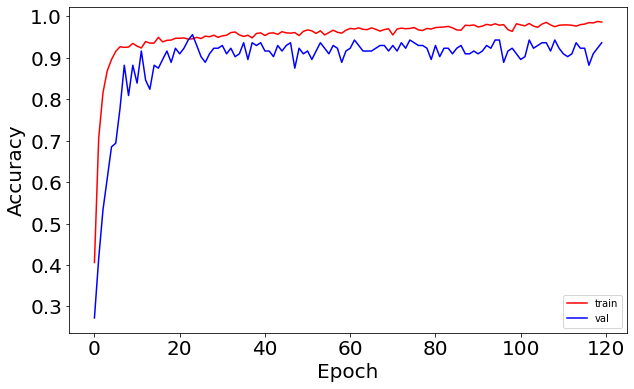

========== dropout [ 0.0 ][ 2 ]===========


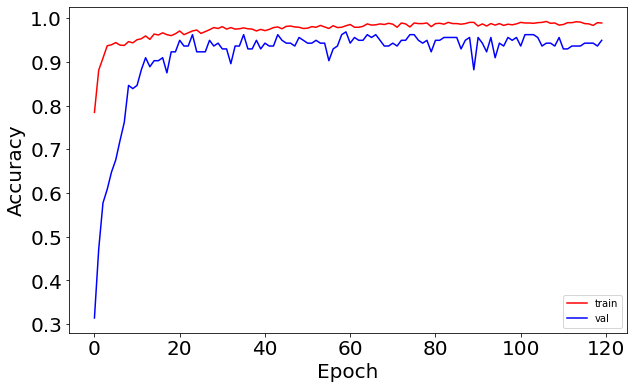

========== dropout [ 0.0 ][ 3 ]===========


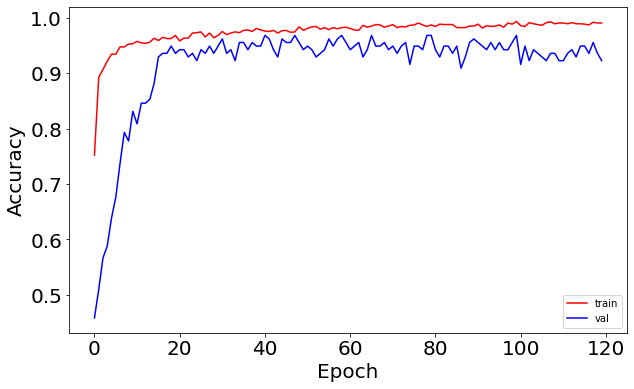

========== dropout [ 0.0 ][ 4 ]===========


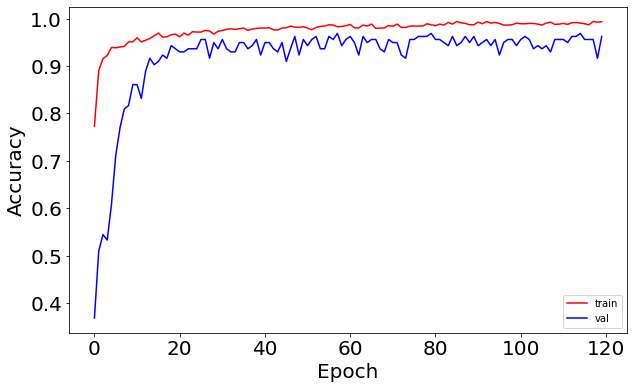

========== dropout [ 0.0 ][ 5 ]===========


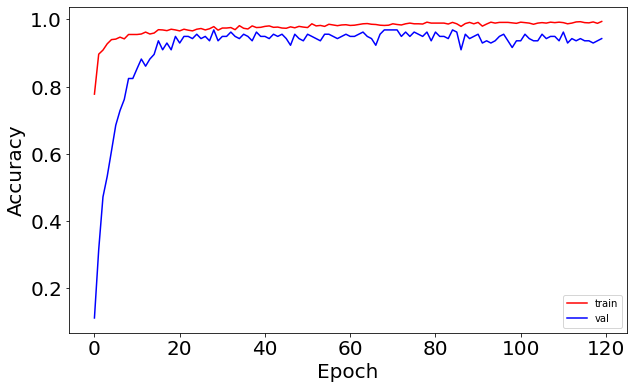

========== dropout [ 0.1 ][ 1 ]===========


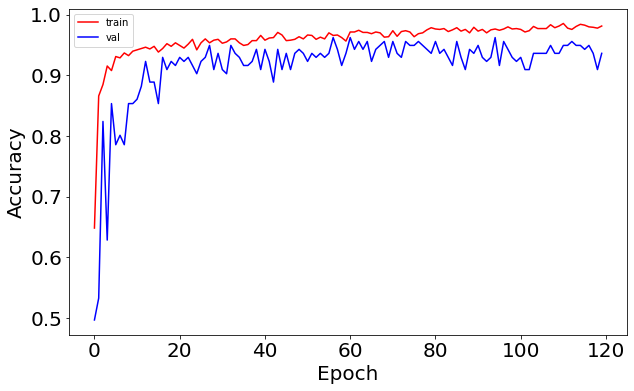

========== dropout [ 0.1 ][ 2 ]===========


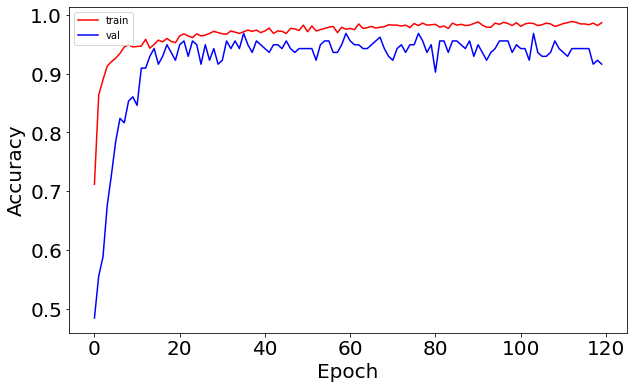

========== dropout [ 0.1 ][ 3 ]===========


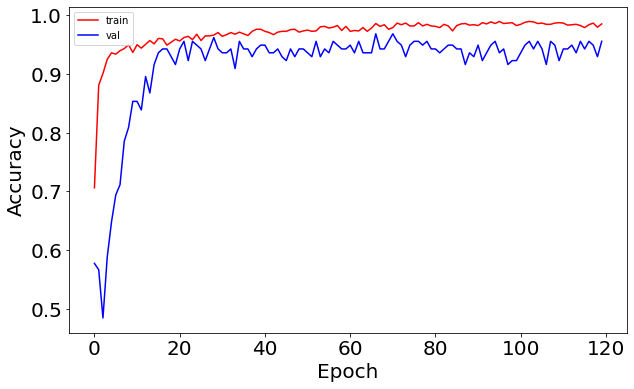

========== dropout [ 0.1 ][ 4 ]===========


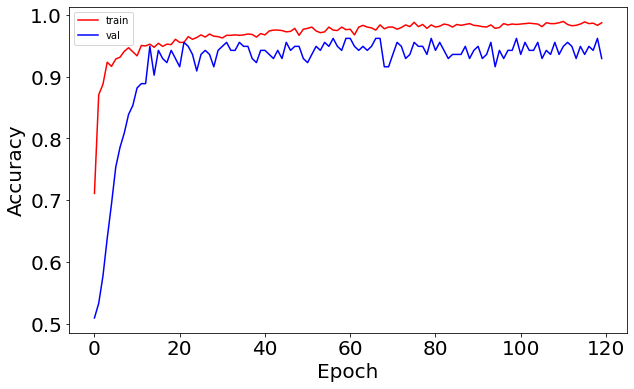

========== dropout [ 0.1 ][ 5 ]===========


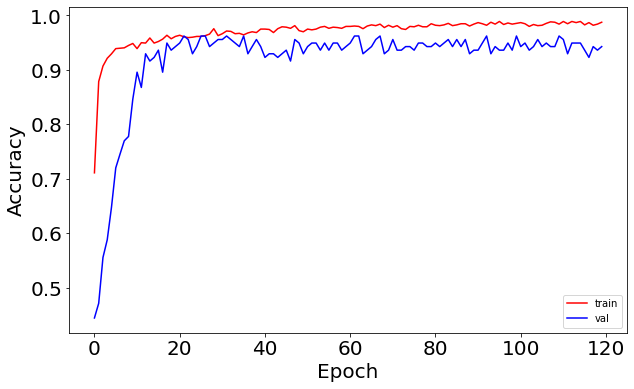

========== dropout [ 0.2 ][ 1 ]===========


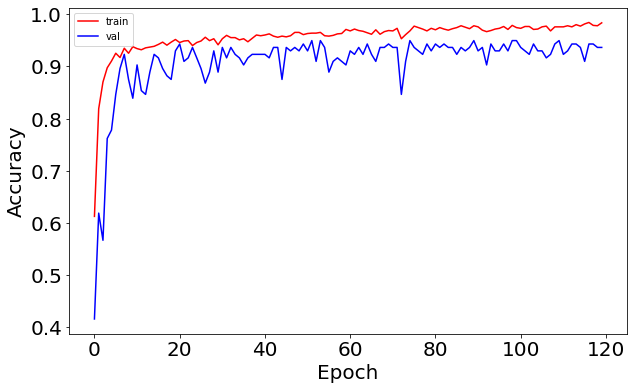

========== dropout [ 0.2 ][ 2 ]===========


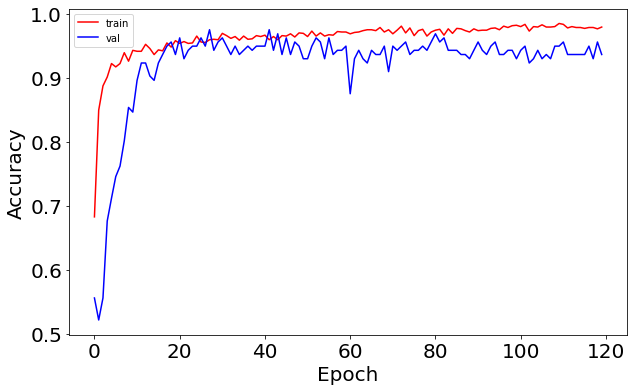

========== dropout [ 0.2 ][ 3 ]===========


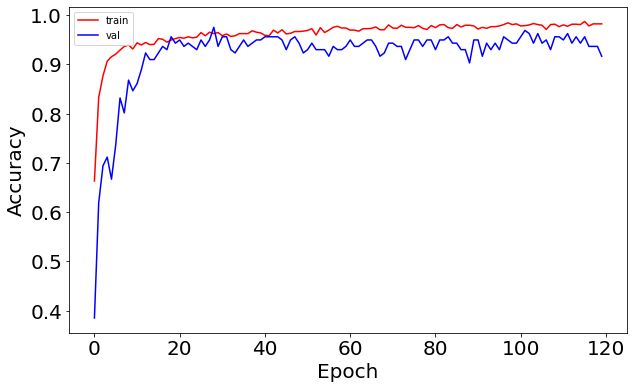

========== dropout [ 0.2 ][ 4 ]===========


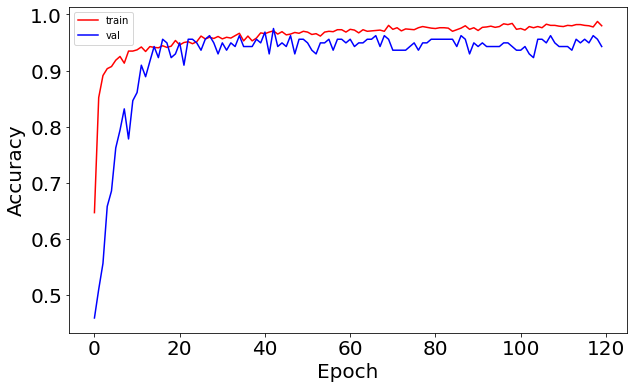

========== dropout [ 0.2 ][ 5 ]===========


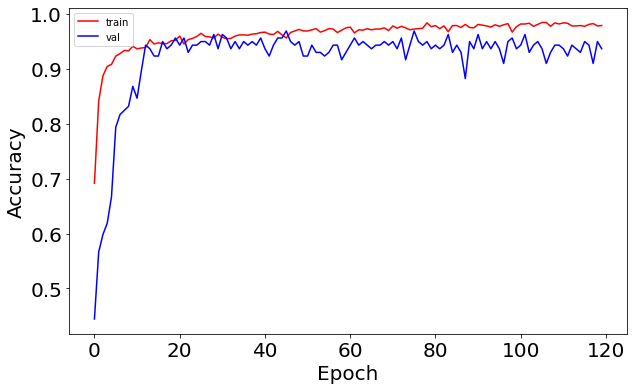

========== dropout [ 0.3 ][ 1 ]===========


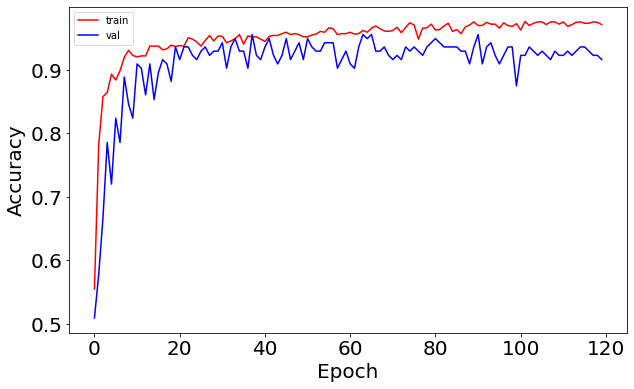

========== dropout [ 0.3 ][ 2 ]===========


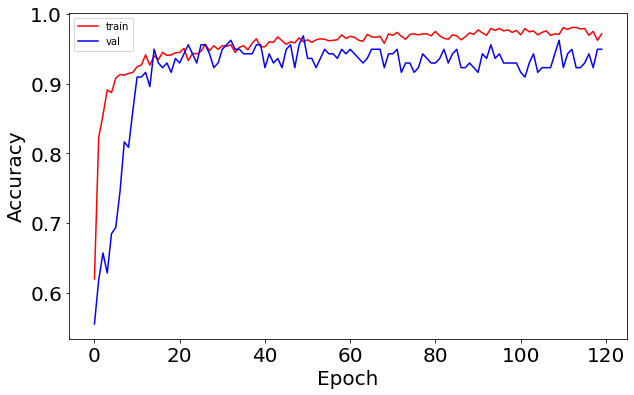

========== dropout [ 0.3 ][ 3 ]===========


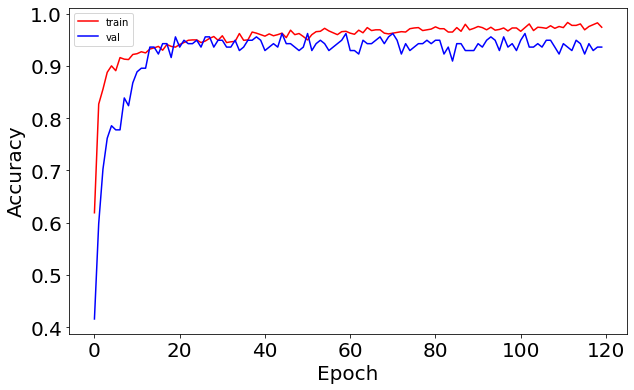

========== dropout [ 0.3 ][ 4 ]===========


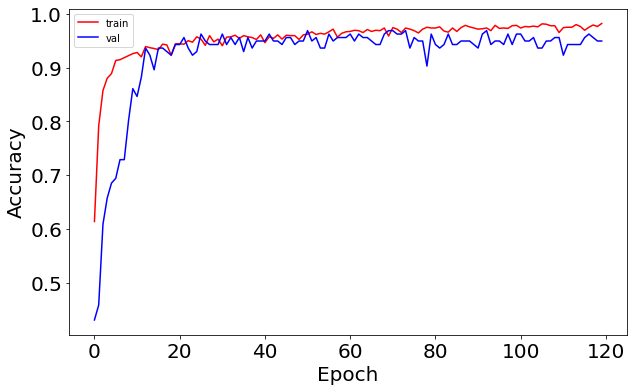

========== dropout [ 0.3 ][ 5 ]===========


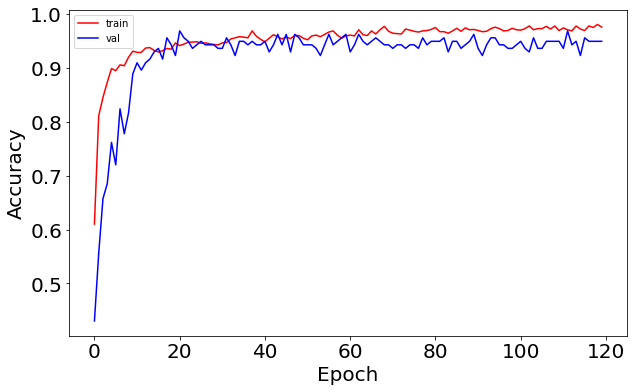

========== dropout [ 0.4 ][ 1 ]===========


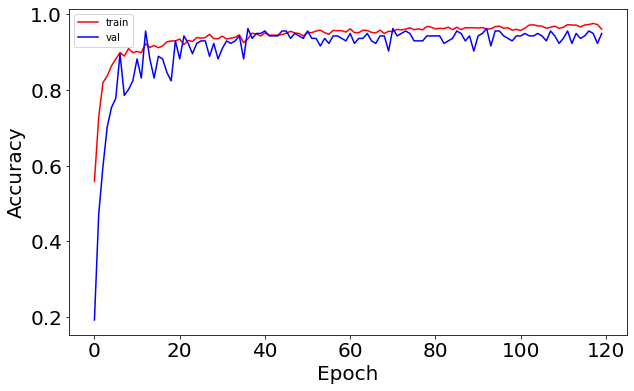

========== dropout [ 0.4 ][ 2 ]===========


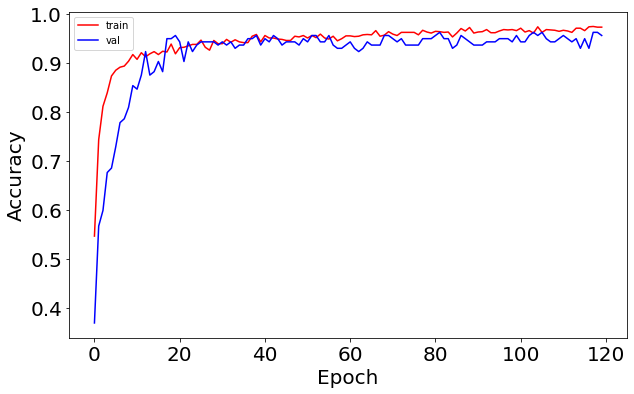

========== dropout [ 0.4 ][ 3 ]===========


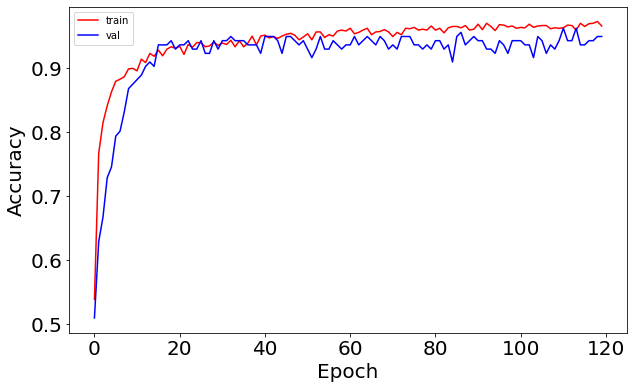

========== dropout [ 0.4 ][ 4 ]===========


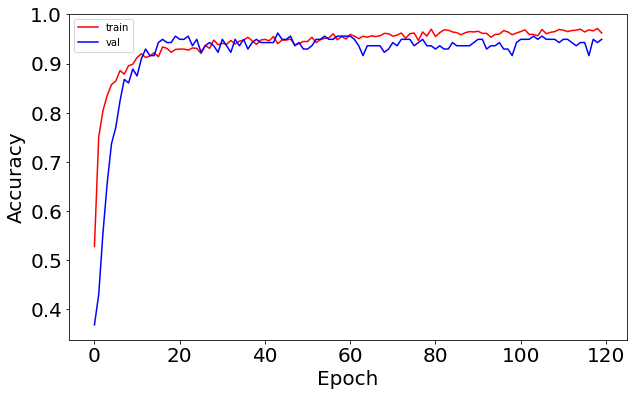

========== dropout [ 0.4 ][ 5 ]===========


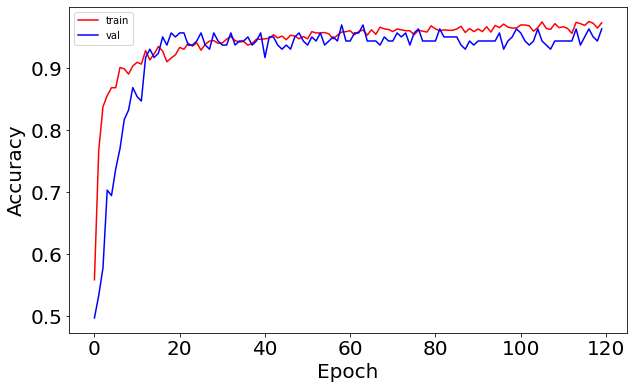

========== dropout [ 0.5 ][ 1 ]===========


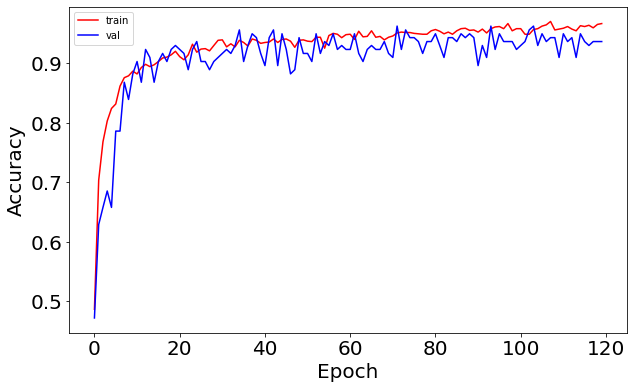

========== dropout [ 0.5 ][ 2 ]===========


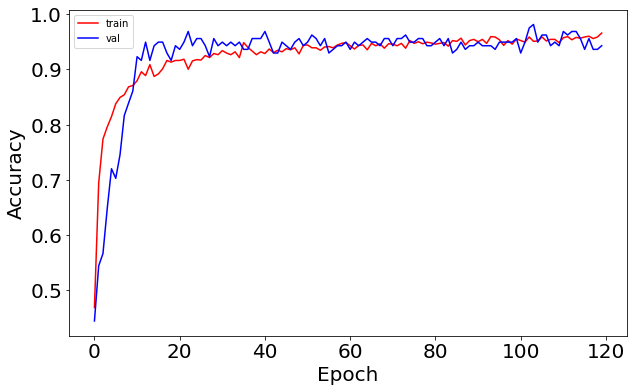

========== dropout [ 0.5 ][ 3 ]===========


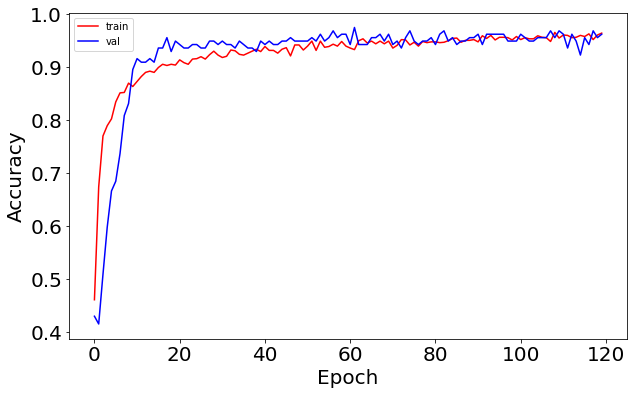

========== dropout [ 0.5 ][ 4 ]===========


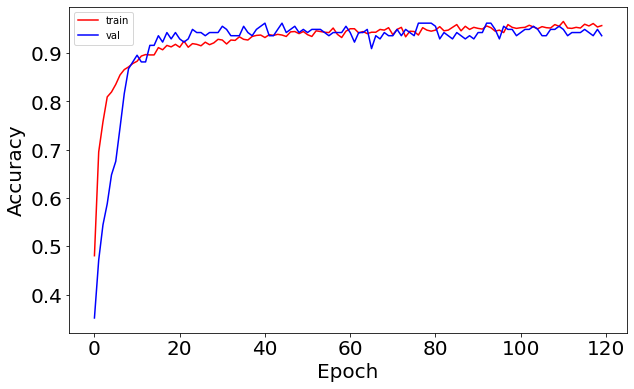

========== dropout [ 0.5 ][ 5 ]===========


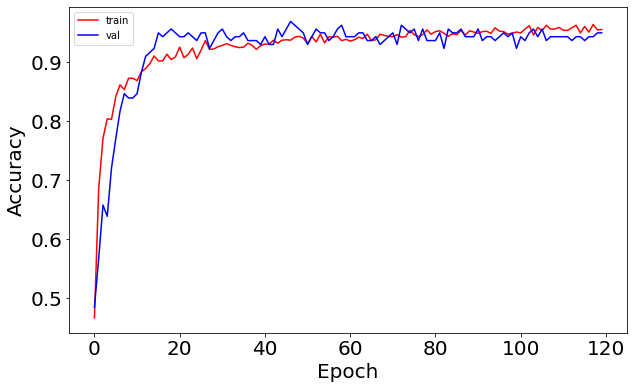

========== dropout [ 0.6 ][ 1 ]===========


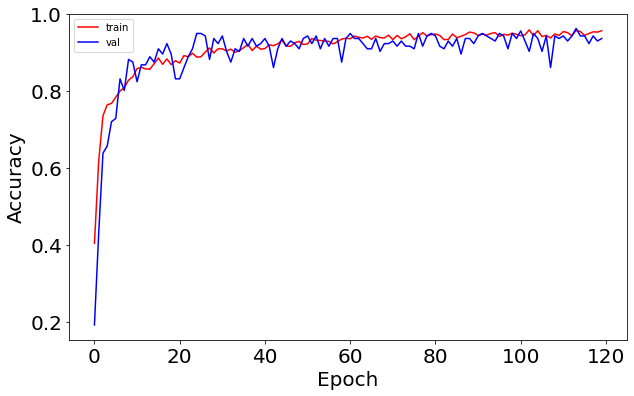

========== dropout [ 0.6 ][ 2 ]===========


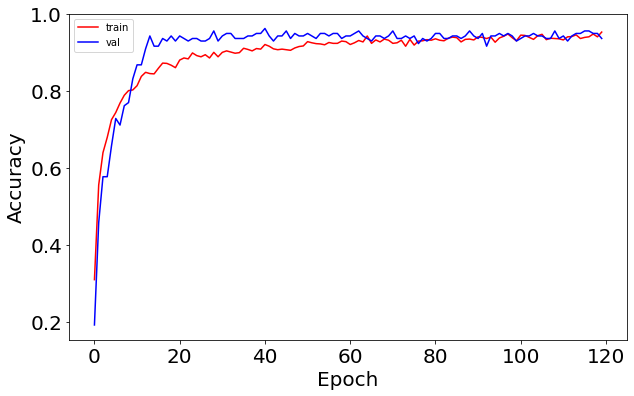

========== dropout [ 0.6 ][ 3 ]===========


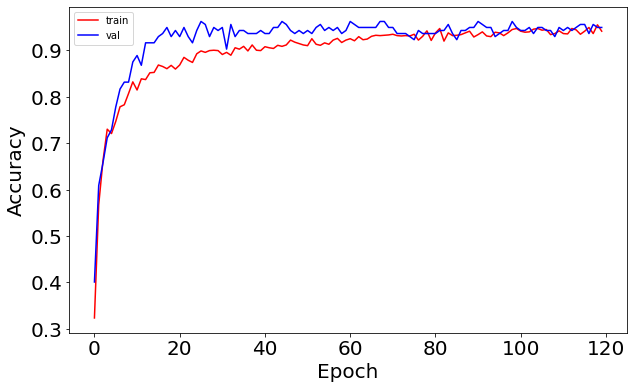

========== dropout [ 0.6 ][ 4 ]===========


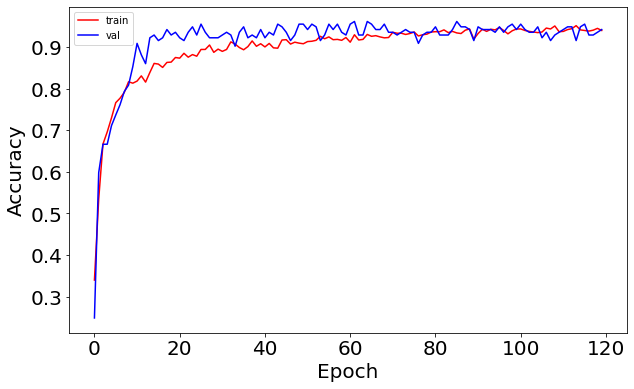

========== dropout [ 0.6 ][ 5 ]===========


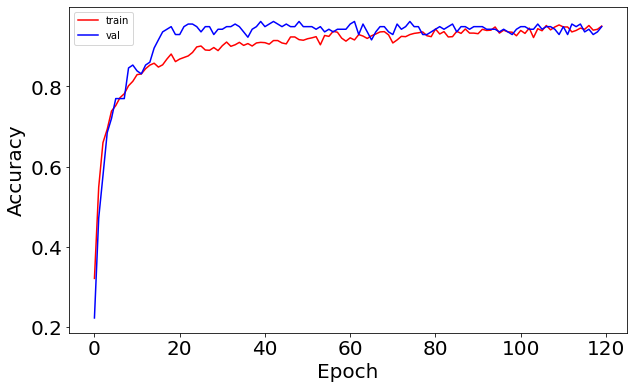

In [76]:
dropout_rate = 0.0
layer = 1
for g in gestures:
  if layer == 6:
    layer = 1
    dropout_rate += 0.1
  print("========== dropout [", round(dropout_rate,1) , "][", layer,"]===========")
  # plot_loss(g)
  plot_accurancy(g)
  layer += 1